In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows =1000
pd.options.display.max_columns=20



In [2]:
train=pd.read_csv('train.csv')

In [3]:
test=pd.read_csv('test.csv')

In [4]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [5]:
missing=train.isnull().sum()

In [6]:
missing=missing[missing>0]

In [7]:
missing.sort_values(ascending=False,inplace=True)

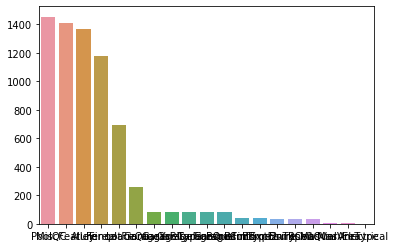

In [8]:
sns.barplot(x=missing.index,y=missing.values)

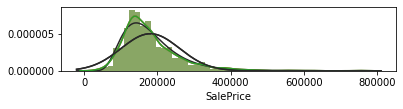

In [9]:
fig=plt.figure()
ax1=fig.add_subplot(3,1,1)

sns.distplot(train['SalePrice'],kde=True,fit=stats.norm)
sns.distplot(train['SalePrice'],kde=True,fit=stats.lognorm)
sns.distplot(train['SalePrice'],kde=True,fit=stats.norm)

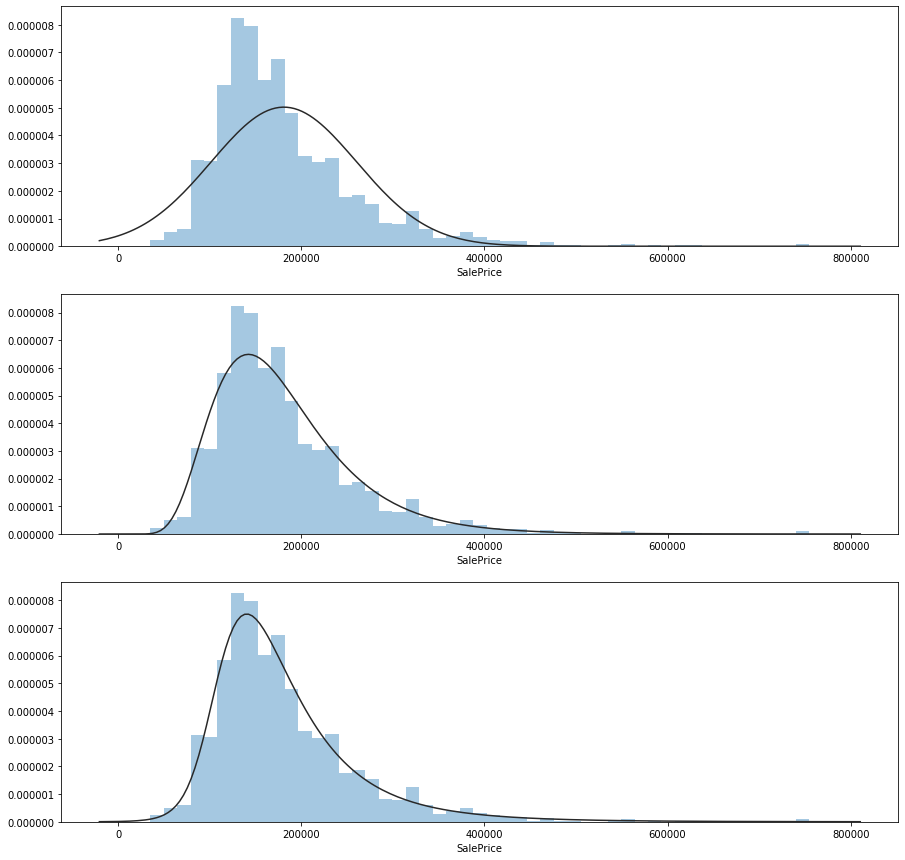

In [10]:
fig,ax=plt.subplots(3,1,figsize=(15,15))
sns.distplot(train['SalePrice'],kde=False,ax=ax[0],fit=stats.norm)
sns.distplot(train['SalePrice'],kde=False,ax=ax[1],fit=stats.lognorm)
sns.distplot(train['SalePrice'],kde=False,ax=ax[2],fit=stats.johnsonsu)


In [11]:
pd.melt(train).head(30)

,variable,value
0,Id,1
1,Id,2
2,Id,3
3,Id,4
4,Id,5
5,Id,6
6,Id,7
7,Id,8
8,Id,9
9,Id,10


In [12]:
a=sns.load_dataset('tips')

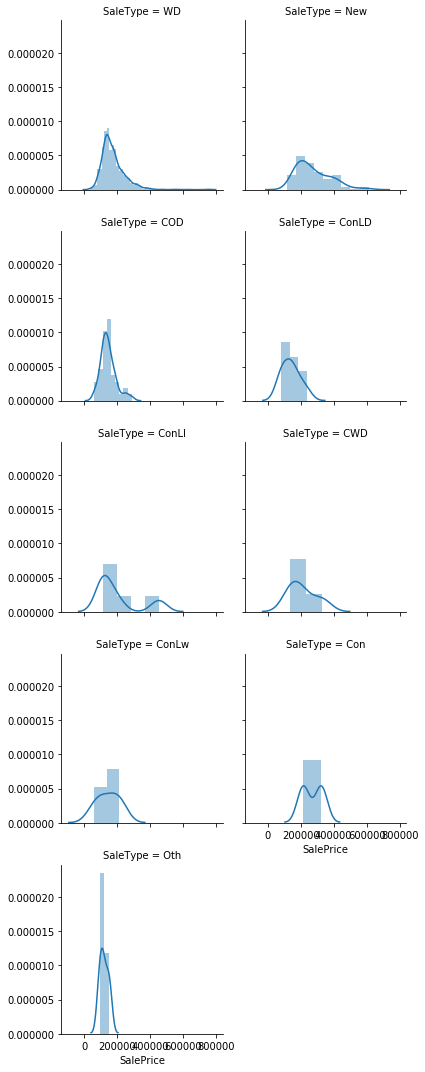

In [13]:
b=sns.FacetGrid(train,col='SaleType',col_wrap=2)
b.map(sns.distplot,'SalePrice')

In [14]:
pd.melt(train,value_vars=quantitative).shape

(52560, 2)

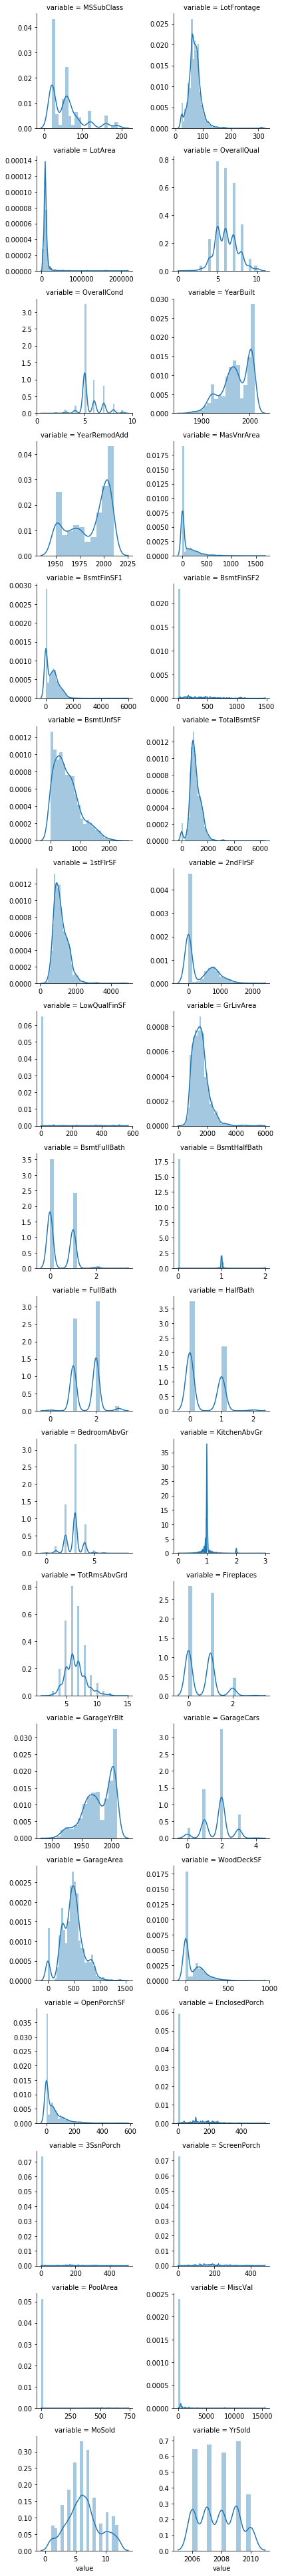

In [15]:
a=pd.melt(train,value_vars=quantitative)
b=sns.FacetGrid(a,col="variable",col_wrap=2,sharex=False,sharey=False)
b.map(sns.distplot,"value")

In [16]:
for c in qualitative:
    train[c]=train[c].astype('category')
    if train[c].isnull().any():
        train[c]=train[c].cat.add_categories(['MISSING'])
        train[c]=train[c].fillna('MISSING')
    

In [17]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath 

In [18]:
f=pd.melt(train,id_vars=['SalePrice'],value_vars=qualitative)

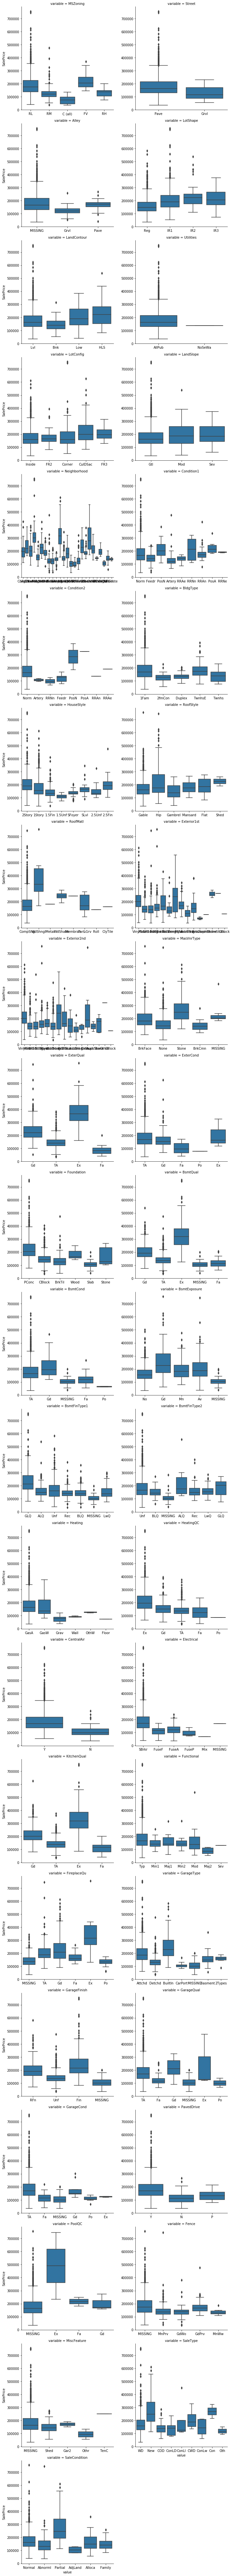

In [19]:
g=sns.FacetGrid(f,col="variable",col_wrap=2,sharex=False,sharey=False,size=5)
g=g.map(sns.boxplot,'value','SalePrice')

In [20]:
frame=train
anv=pd.DataFrame()
anv['feature']=qualitative
pvals=[]
for c in qualitative:
    samples=[]
    for cls in frame[c].unique():
        s=frame[frame[c]==cls]['SalePrice'].values
        samples.append(s)
    pval=stats.f_oneway(*samples)[1]
    pvals.append(pval)
anv['pval']=pvals
anv=anv.sort_values('pval')
      

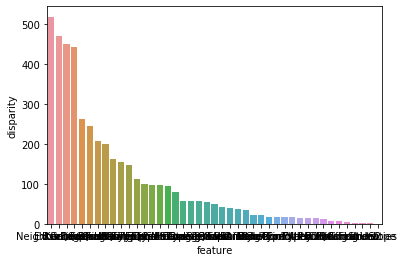

In [21]:
anv['disparity']=np.log(1./anv['pval'].values)
sns.barplot(data=anv,x='feature',y='disparity')

In [22]:
def encode(frame,feature):
##feature='MSZoning'
    ordering =pd.DataFrame()
    ordering['val']=frame[feature].unique()
    ordering.index=ordering.val
    ordering['spmean']=frame[[feature,'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering=ordering.sort_values('spmean')
    ordering['ordering']=range(1,ordering.shape[0]+1)
    ordering=ordering['ordering'].to_dict()
    for cat ,o in ordering.items():
        frame.loc[frame[feature]==cat,feature+'_E']=o
qual_encoded=[]
for q in qualitative:
    encode(train,q)
    qual_encoded.append(q+'_E')
        
        

In [23]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
1,2,20,RL,80.0,9600,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
2,3,60,RL,68.0,11250,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
3,4,70,RL,60.0,9550,Pave,MISSING,IR1,Lvl,AllPub,...,3.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,2.0
4,5,60,RL,84.0,14260,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


In [24]:
a=input()


In [25]:
features=quantitative
standard=train[train['SalePrice']<200000]
pricey=train[train['SalePrice']>=200000]

In [26]:
diff=pd.DataFrame()
diff['feature']=features
diff['difference']=[(pricey[f].fillna(0.).mean()-standard[f].fillna(0.).mean())/standard[f].fillna(0.).mean() for f in features]

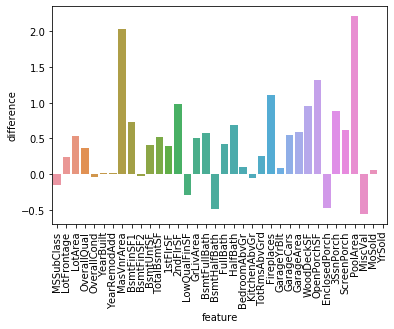

In [27]:
sns.barplot(data=diff,x='feature',y='difference')
x=plt.xticks(rotation=90)

In [28]:
X=train[features].fillna(0.).values
X

array([[6.000e+01, 6.500e+01, 8.450e+03, ..., 0.000e+00, 2.000e+00,
        2.008e+03],
       [2.000e+01, 8.000e+01, 9.600e+03, ..., 0.000e+00, 5.000e+00,
        2.007e+03],
       [6.000e+01, 6.800e+01, 1.125e+04, ..., 0.000e+00, 9.000e+00,
        2.008e+03],
       ...,
       [7.000e+01, 6.600e+01, 9.042e+03, ..., 2.500e+03, 5.000e+00,
        2.010e+03],
       [2.000e+01, 6.800e+01, 9.717e+03, ..., 0.000e+00, 4.000e+00,
        2.010e+03],
       [2.000e+01, 7.500e+01, 9.937e+03, ..., 0.000e+00, 6.000e+00,
        2.008e+03]])

In [29]:
features=quantitative+qual_encoded
model= TSNE(n_components=2,random_state=0,perplexity=50)
X=train[features].fillna(0.).values
tsne=model.fit_transform(X)

In [30]:
std=StandardScaler()
s=std.fit_transform(X)
pca=PCA(n_components=30)
pca.fit(s)
pc=pca.transform(s)
kmeans=KMeans(n_clusters=5)
kmeans.fit(pc)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
fr=pd.DataFrame({'tsne1':tsne[:,0],'tsne2':tsne[:,1],'cluster':kmeans.labels_})

In [42]:
model=TSNE(n_components=2,random_state=0,perplexity=30)
tsne=model.fit_transform(X)


array([[ -0.5011153 , -35.689705  ],
       [ -0.74160606,  -0.13092199],
       [-28.51086   , -14.105763  ],
       ...,
       [  3.289836  , -11.405737  ],
       [  2.0337322 ,  -6.2436867 ],
       [ -5.8006067 ,   0.7076139 ]], dtype=float32)

In [46]:
std=StandardScaler()
s=std.fit_transform(X)
pca=PCA(n_components=30)
pca.fit(s)
pc=pca.transform(s)
kmeans=KMeans(n_cluster=5)
kmeans.fit(pc)


30

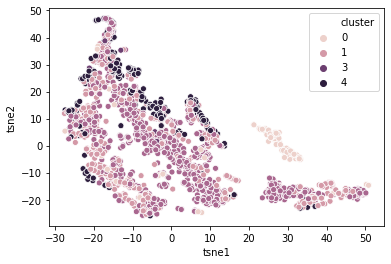

In [49]:
sns.scatterplot(data=fr,x='tsne1',y='tsne2',hue='cluster')

In [33]:
print(np.sum(pca.explained_variance_ratio_))

0.7500555578498717


In [58]:
def error(actual,predicted):
    actual=np.log(actual)
    predicted=np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature]=np.log1p(train[feature].values)
def quadratic(feature):
    train[feature+'2']=train[feature]**2




In [51]:
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

In [53]:
train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)


In [54]:
boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

In [55]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,RoofMatl_E2,GrLivArea2,HasBasement,HasGarage,Has2ndFloor,HasMasVnr,HasWoodDeck,HasPorch,HasPool,IsNew
0,1,60,RL,4.189655,9.042040,Pave,MISSING,Reg,Lvl,AllPub,...,9.0,55.425542,1,1,1,1,0,1,0,1
1,2,20,RL,4.394449,9.169623,Pave,MISSING,Reg,Lvl,AllPub,...,9.0,50.997382,1,1,0,0,1,0,0,0
2,3,60,RL,4.234107,9.328212,Pave,MISSING,IR1,Lvl,AllPub,...,9.0,56.074540,1,1,1,1,0,1,0,1
3,4,70,RL,4.110874,9.164401,Pave,MISSING,IR1,Lvl,AllPub,...,9.0,55.486351,1,1,1,0,0,1,0,0
4,5,60,RL,4.442651,9.565284,Pave,MISSING,IR1,Lvl,AllPub,...,9.0,59.224691,1,1,1,1,1,1,0,0


In [59]:
feature=quantitative+qual_encoded+boolean+qdr
lasso=linear_model.LassoLarsCV(max_iter=10000)
X=train[feature].fillna(0.).values
Y=train['SalePrice'].values
lasso.fit(X,np.log(Y))
Ypred=np.exp(lasso.predict(X))
error(Y,Ypred)

0.1126326901784312

In [62]:
import patsy
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.11602320727290548
